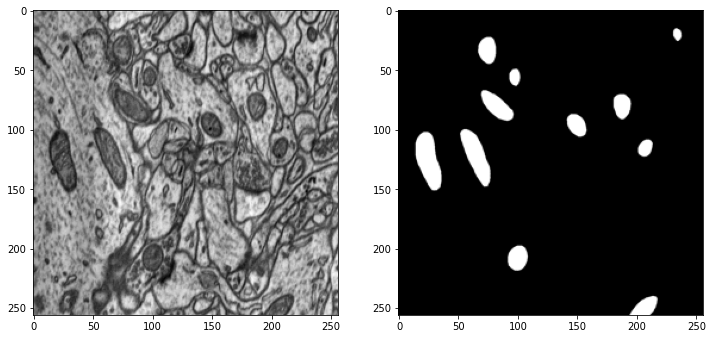

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

C:\Users\FYQ\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 1s 514ms/step - loss: 0.2429 - accuracy: 0.9362
Accuracy =  93.62290501594543 %


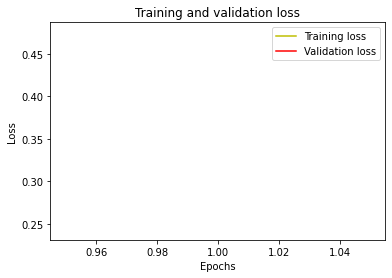

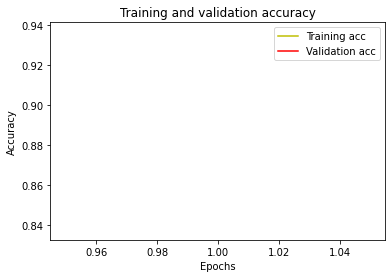

1/1 [==============================] - 1s 689ms/step
IoU socre is:  1.4074793452406086e-05
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
 

In [1]:
# https://youtu.be/csFGTLT6_WQ
"""
Author: Dr. Sreenivas Bhattiprolu

Training and testing for semantic segmentation (Unet) of mitochondria
Uses standard Unet framework with no tricks!

Dataset info: Electron microscopy (EM) dataset from
https://www.epfl.ch/labs/cvlab/data/data-em/

Patches of 256x256 from images and labels
have been extracted (via separate program) and saved to disk.


This code uses 256x256 images/masks.

To annotate images and generate labels, you can use APEER (for free):
www.apeer.com
"""

from simple_unet_model import simple_unet_model  # Use normal unet model
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

image_directory = 'data/generated_patches/images/'
mask_directory = 'data/generated_patches/masks/'

SIZE = 256
image_dataset = []  # Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  # Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = os.listdir(image_directory)
for i, image_name in enumerate(images):  # Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        # print(image_directory+image_name)
        image = cv2.imread(image_directory + image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

# Iterate through all images in Uninfected folder, resize to 64 x 64
# Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory + image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

# Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1), 3)
# D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)), 3) / 255.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.10, random_state=0)

# Sanity check, view few mages
import random
import numpy as np

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

###############################################################
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]


def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


model = get_model()

# If starting with pre-trained weights.
# model.load_weights('mitochondria_gpu_tf1.4.hdf5')

history = model.fit(X_train, y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=1,
                    validation_data=(X_test, y_test),
                    shuffle=False)

model.save('mitochondria_test.hdf5')

############################################################
# Evaluate the model


# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# acc = history.history['acc']
acc = history.history['accuracy']
# val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##################################
# IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#######################################################################
# Predict on a few images
model = get_model()
model.load_weights('mitochondria_test.hdf5')  # Trained for 50 epochs and then additional 100
# model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.2).astype(np.uint8)


In [22]:

test_img_other = Image.open(r'D:\multi_media\DOC\Study\python\AI\Deep '
                            r'Learn\Pytorch_project\Machine-Learning-Collection-master('
                            r'U-net)\ML\Pytorch\image_segmentation\semantic_segmentation_unet\tensorflow\data'
                            r'\testing_page_0004.tif')

In [28]:
# print(test_img_other)
# print(test_img_other.shape)
# cv2.imshow('fds', test_img_other)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# test_img_other2 = np.expand_dims(test_img_other, axis=2).astype(np.float32)
# print(test_img_other.shape)
# test_img_other = cv2.resize(test_img_input, (512, 256))
test_img_other2 = test_img_other.resize((256, 256))
test_img_other2 = np.array(test_img_other2)
test_img_other2 = np.expand_dims(test_img_other2, axis=2)
test_img_other2 = np.expand_dims(test_img_other2, axis=0)
print(test_img_other2.shape)

(1, 256, 256, 1)


1/1 [==============================] - 0s 241ms/step


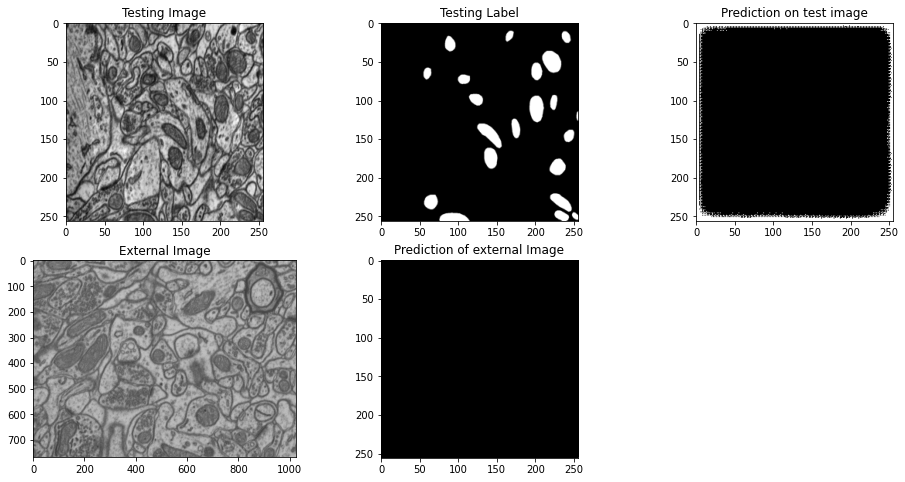

In [29]:
# test_img_other = cv2.imread('data/test_images/img8.tif', 0)
# test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1), 2)
# test_img_other_norm = test_img_other_norm[:, :, 0][:, :, None]
# test_img_other_input = np.expand_dims(test_img_other_norm, 0)

# Predict and threshold for values above 0.5 probability
# Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(np.array(test_img_other2))[0, :, :, 0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:, :, 0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

# plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
# plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')
